In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io.votable import parse
from astropy.io.votable import parse_single_table
import matplotlib.patches as patches

In [13]:
# Data Paths
hyades_data = 'Data/TestData7.vot'

<h2>Extracting data from the .VOT file</h2>

In [14]:
table = parse_single_table(hyades_data)
print(table.fields)
data = table.array

"""
FIELD ID="ra" datatype="double" name="ra" ucd="pos.eq.ra;meta.main" unit="deg"
FIELD ID="pmra" datatype="float" name="pmra" unit="mas / yr"/
FIELD ID="radial_velocity" datatype="float" name="radial_velocity" unit="km / s"
"""

[<FIELD ID="tycho2sources_oid" datatype="int" name="tycho2sources_oid"/>, <FIELD ID="id" arraysize="*" datatype="char" name="id"/>, <FIELD ID="hip" datatype="int" name="hip"/>, <FIELD ID="ra" datatype="double" name="ra" ucd="pos.eq.ra;meta.main" unit="deg" utype="Char.SpatialAxis.Coverage.Location.Coord.Position2D.Value2.C1"/>, <FIELD ID="dec" datatype="double" name="dec" ucd="pos.eq.dec;meta.main" unit="deg" utype="Char.SpatialAxis.Coverage.Location.Coord.Position2D.Value2.C2"/>, <FIELD ID="pmra" datatype="float" name="pmra" unit="mas / yr"/>, <FIELD ID="pmdec" datatype="float" name="pmdec" unit="mas / yr"/>, <FIELD ID="pmra_error" datatype="float" name="pmra_error" unit="mas / yr"/>, <FIELD ID="pmdec_error" datatype="float" name="pmdec_error" unit="mas / yr"/>, <FIELD ID="radial_velocity" datatype="float" name="radial_velocity" ucd="spect.dopplerVeloc.opt;em.opt.I" unit="km / s" utype="stc:AstroCoords.Velocity3D.Value3.C3"/>]


'\nFIELD ID="ra" datatype="double" name="ra" ucd="pos.eq.ra;meta.main" unit="deg"\nFIELD ID="pmra" datatype="float" name="pmra" unit="mas / yr"/\nFIELD ID="radial_velocity" datatype="float" name="radial_velocity" unit="km / s"\n'

<h2>Selecting Members Using Proper Motions</h2>

In [4]:
def get_cond(pmra_range, pmdec_range):
    """
    define condition based on ranges of dec and ra
    """
    cond = ((data['pmra'] > pmra_range[0]) & (data['pmra'] < pmra_range[1]) & (data['pmdec'] > pmdec_range[0]) & (data['pmdec'] < pmdec_range[1]))
    return cond

In [5]:
def plot_selected_pm(data, cond):
    """
    Selects proper motion of members based on given conidtion and data. Plots the selected members' pm.
    Returns selected members' pm
    """
    selected_data = data[cond]
    selected_pmra = data['pmra'][cond]
    selected_pmdec = data['pmdec'][cond]
    
    plt.plot(data['pmra'], data['pmdec'], '.', label='Field')
    plt.plot(selected_pmra, selected_pmdec, '.', label='Hyades')
    plt.xlim(-150, 200)
    plt.ylim(-150, 100)

    plt.xlabel('Proper Motion in RA (mas/yr)')
    plt.ylabel('Proper Motion in DEC (mas/yr)')
    plt.legend()
    plt.savefig('pm_cluster.pdf')
    plt.show()
    return selected_pmra, selected_pmdec, selected_data

def plot_selected_coords(data, cond):
    """
    Selects the cluster members' coords based on a condition and given data. Plots selected coords.
    Returns selected members' coords.
    """
    selected_ra = data['ra'][cond]
    selected_dec = data['dec'][cond]

    plt.plot(data['ra'], data['dec'], '.')
    plt.plot(selected_ra, selected_dec, '.')
    plt.show()
    return selected_ra, selected_dec

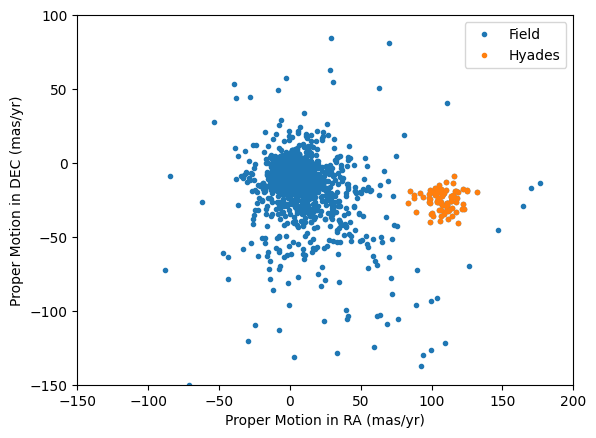

In [6]:
plt.close()

# Define ranges of pm
pmra_range = (80, 132) # Range of proper motions in ra that correspond to members
pmdec_range = (-45, -8) # Range of proper motions in dec that correspond to members

# Define a condition based on the ranges
cond = get_cond(pmra_range, pmdec_range)

selected_pmra, selected_pmdec, selected_data = plot_selected_pm(data, cond)

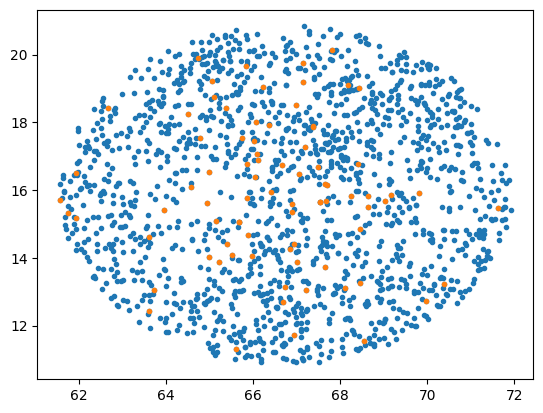

In [7]:
plt.close()
selected_ra, selected_dec = plot_selected_coords(data, cond)

<h2>Getting to the Convergent Point</h2>

(96.26262626262627, 8.84848484848485)


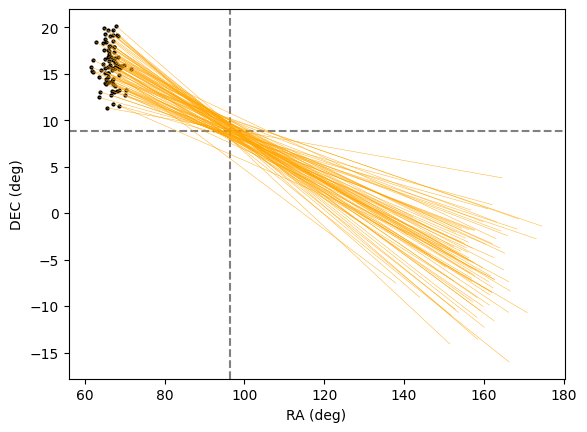

In [8]:
# %matplotlib widget
def CP_members(member_ra, member_dec, member_pmra, member_pmdec, t_tot = 10**6.5, patch=False):
    # t_tot = 10**6.5 # Amount of time in years
    fig = plt.figure()
    ax = fig.subplots(1)
    ax.plot(member_ra, member_dec, 'k.', markersize=4)
    member_ra_final = member_ra + member_pmra * t_tot * 2.7e-7 
    member_dec_final = member_dec + member_pmdec * t_tot * 2.7e-7
    
    # Create arrays that represent the ra and dec values we want to scan across
    min_ra, max_ra = 70, 120 
    min_dec, max_dec = 0, 12
    n_bins = 100
    ra_vals = np.linspace(min_ra, max_ra, n_bins)
    dec_vals = np.linspace(min_dec, max_dec, n_bins)

    # For each value in ra_vals, calculate dec of each member
    interped_dec = []
    interped_ra = []
    
    for i in range(len(member_ra)):
        interped_dec.append(np.interp(ra_vals, [member_ra[i], member_ra_final[i]], [member_dec[i], member_dec_final[i]]))
        # ax.plot(ra_vals, interped_dec[i], linestyle='dashed')
        interped_ra.append(np.interp(dec_vals, [member_dec_final[i], member_dec[i]], [member_ra_final[i], member_ra[i]]))
        # ax.plot(interped_ra[i], dec_vals, linestyle='dashed')
    
    var_dec = np.var(interped_dec, axis=0)
    ax.axvline(ra_vals[np.argmin(var_dec)], linestyle='dashed', color='grey')
    var_ra = np.var(interped_ra, axis=0)
    ax.axhline(dec_vals[np.argmin(var_ra)], linestyle='dashed', color='grey')
    CP = (ra_vals[np.argmin(var_dec)], dec_vals[np.argmin(var_ra)])
    print(CP)
    
    for i in range(len(member_ra)):
        ax.plot([member_ra_final[i], member_ra[i]], [member_dec_final[i], member_dec[i]], 'orange', linewidth=0.3)
    # plt.xlim(-150, 200)
    # plt.ylim(-150, 100)

    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('DEC (deg)')
    fig.savefig('CP_cluster.pdf')
    rect = patches.Rectangle((90, 11), 10, -4, linewidth=1, edgecolor='b', facecolor='none', alpha=1)
    
    # Calculating Variances
    min_ra, max_ra = 60, 120
    ra_range = np.linspace(min_ra, max_ra)
    # ra_val = np.interp(ra_range, member_ra[0], member_ra_final[0])
    # print(ra_val)
              
    if patch:
        ax.add_patch(rect)
    # fig.show()
    fig.savefig('CP_cluster.pdf')
    return CP, var_ra, var_dec

plt.close()
CP, var_ra, var_dec = CP_members(selected_ra, selected_dec, selected_pmra, selected_pmdec)

<h2>Calculating Distances</h2>

In [12]:
def calc_individual_dist(members_ra, members_dec, members_pmra, members_pmdec, rad_vel, CP):
    CP_RA = CP[0]
    CP_DE = CP[1]
    theta = np.arccos(np.sin(np.deg2rad(members_dec)) * np.sin(np.deg2rad(CP_DE)) + np.cos(np.deg2rad(members_dec)) 
                      * np.cos(np.deg2rad(CP_DE)) * np.cos(np.deg2rad(members_ra) - np.deg2rad(CP_RA)))
    # print(theta)
    pm_abs = np.sqrt(members_pmra**2 + members_pmdec**2)
    dist = (rad_vel * np.tan(theta)) / (4.74047 * pm_abs)
    avg_dist_pc = dist.mean() * 1000
    return avg_dist_pc

ConvPoint_avg = CP # Convergent point in RA, DEC 
avg_dist = calc_individual_dist(selected_ra, selected_dec, selected_pmra, selected_pmdec, selected_data['radial_velocity'], ConvPoint_avg)
print('Average Distance to CLuster (pc):', int(avg_dist.round(0)))

Average Distance to CLuster (pc): 44
